In [1]:
import os
import tarfile
import urllib
import zipfile
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from pandas.plotting import scatter_matrix

from sklearn.impute import SimpleImputer

from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error

from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier

from sklearn.svm import SVR

from sklearn.model_selection import GridSearchCV

from sklearn.base import BaseEstimator,TransformerMixin

In [2]:
HOUSE_PATH = "2211-credit-card-churn-immune/"

def load_housing_data(housing_path=HOUSE_PATH,file_path=None):
    csv_path = os.path.join(housing_path,file_path)
    return pd.read_csv(csv_path)

credit_train = load_housing_data(file_path='train.csv')
credit_test = load_housing_data(file_path='test.csv')

credit_all = pd.concat([credit_train,credit_test])

# Exploración de los datos

In [3]:
credit_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6275 entries, 0 to 1882
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   customer_id                          6275 non-null   int64  
 1   customer_age                         5651 non-null   float64
 2   education_level                      5339 non-null   object 
 3   marital_status                       5815 non-null   object 
 4   income_category                      5572 non-null   object 
 5   number_products_customer             6275 non-null   int64  
 6   weeks_tenure                         6275 non-null   int64  
 7   contacts_last_12mths                 6275 non-null   int64  
 8   credit_limit                         6275 non-null   float64
 9   card_class                           6275 non-null   object 
 10  inactive_months_last_12mths          6275 non-null   int64  
 11  total_revolving_balance       

In [4]:
credit_all.head()

,customer_id,customer_age,education_level,marital_status,income_category,number_products_customer,weeks_tenure,contacts_last_12mths,credit_limit,card_class,inactive_months_last_12mths,total_revolving_balance,count_transactions,transactions_amount,change_transaction_amt_last_3mths,change_transaction_count_last_3mths,churn
0,4278,NaN,phd,NaN,30k€-50k€,4,216,1,16541.0,red plus,2,1428,82,4352,0.846,0.907,0.0
1,7300,45.0,graduate,single,<30k€,5,115,3,1438.3,red,3,576,66,5098,0.774,0.833,0.0
2,6857,NaN,uneducated,married,30k€-50k€,6,172,2,2293.0,red,1,1460,74,4436,0.658,0.542,0.0
3,2508,39.0,graduate,married,70k€-110k€,5,124,2,17523.0,red,2,0,54,1974,0.424,0.688,1.0
4,7859,40.0,graduate,single,<30k€,2,107,2,4391.0,red,2,1933,36,1849,0.579,0.385,1.0


In [5]:
credit_all.describe()

,customer_id,customer_age,number_products_customer,weeks_tenure,contacts_last_12mths,credit_limit,inactive_months_last_12mths,total_revolving_balance,count_transactions,transactions_amount,change_transaction_amt_last_3mths,change_transaction_count_last_3mths,churn
count,6275.000000,5651.000000,6275.000000,6275.000000,6275.000000,6275.000000,6275.000000,6275.000000,6275.000000,6275.000000,6275.000000,6275.000000,4392.000000
mean,5104.035538,45.844806,3.764462,147.376574,2.501833,8604.879602,2.367649,1107.898486,62.367968,4241.140398,0.754040,0.693779,0.260474
std,2941.419420,8.598342,1.559360,32.119624,1.126430,9090.385735,1.006580,843.641019,23.543614,3328.651610,0.221847,0.245113,0.438943
min,2.000000,15.000000,1.000000,53.000000,0.000000,1438.300000,0.000000,0.000000,10.000000,510.000000,0.000000,0.000000,0.000000
25%,2535.000000,40.000000,3.000000,129.000000,2.000000,2532.000000,2.000000,0.000000,43.000000,2083.500000,0.622500,0.556000,0.000000
50%,5117.000000,46.000000,4.000000,148.000000,3.000000,4534.000000,2.000000,1205.000000,64.000000,3658.000000,0.735000,0.685000,0.000000
75%,7678.500000,52.000000,5.000000,165.000000,3.000000,11033.500000,3.000000,1766.000000,79.000000,4707.500000,0.863000,0.809000,1.000000
max,10127.000000,77.000000,6.000000,229.000000,6.000000,34516.000000,6.000000,2517.000000,139.000000,18484.000000,3.397000,3.714000,1.000000


In [6]:
credit_train['churn'].value_counts()

0    3248
1    1144
Name: churn, dtype: int64

In [7]:
credit_train['income_category'].value_counts()

<30k€         1530
30k€-50k€      776
70k€-110k€     682
50k€-70k€      597
+110k€         306
Name: income_category, dtype: int64

In [8]:
credit_train['education_level'].value_counts()

graduate         1353
high school       872
uneducated        632
college           439
post-graduate     232
phd               207
Name: education_level, dtype: int64

In [9]:
credit_train['marital_status'].value_counts()

married     2023
single      1724
divorced     327
Name: marital_status, dtype: int64

In [10]:
credit_train['card_class'].value_counts()

red              4077
red plus          254
red unlimited      53
premium             8
Name: card_class, dtype: int64

# Visualizar y descubrir datos

In [11]:
attributes_num = [name for name in credit_train.columns if credit_train[name].dtype in ['int64', 'float64']]
credit_num = credit_train[attributes_num]
credit_num

,customer_id,customer_age,number_products_customer,weeks_tenure,contacts_last_12mths,credit_limit,inactive_months_last_12mths,total_revolving_balance,count_transactions,transactions_amount,change_transaction_amt_last_3mths,change_transaction_count_last_3mths,churn
0,4278,NaN,4,216,1,16541.0,2,1428,82,4352,0.846,0.907,0
1,7300,45.0,5,115,3,1438.3,3,576,66,5098,0.774,0.833,0
2,6857,NaN,6,172,2,2293.0,1,1460,74,4436,0.658,0.542,0
3,2508,39.0,5,124,2,17523.0,2,0,54,1974,0.424,0.688,1
4,7859,40.0,2,107,2,4391.0,2,1933,36,1849,0.579,0.385,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4387,8590,27.0,5,147,3,3184.0,2,1421,59,2253,0.712,0.439,0
4388,8131,50.0,3,175,0,5139.0,3,0,44,1653,0.330,0.692,1
4389,3445,48.0,3,180,2,2094.0,3,0,46,2690,0.897,0.484,1
4390,2832,NaN,1,116,3,5821.0,2,894,42,2011,0.461,0.273,1


In [12]:
corr_matrix = credit_num.corr()
corr_matrix['churn'].sort_values(ascending=False)

churn                                  1.000000
contacts_last_12mths                   0.247230
inactive_months_last_12mths            0.195645
customer_age                           0.032870
weeks_tenure                           0.018859
customer_id                           -0.005258
credit_limit                          -0.030620
change_transaction_amt_last_3mths     -0.157887
number_products_customer              -0.179723
transactions_amount                   -0.206259
total_revolving_balance               -0.313688
change_transaction_count_last_3mths   -0.333706
count_transactions                    -0.438859
Name: churn, dtype: float64

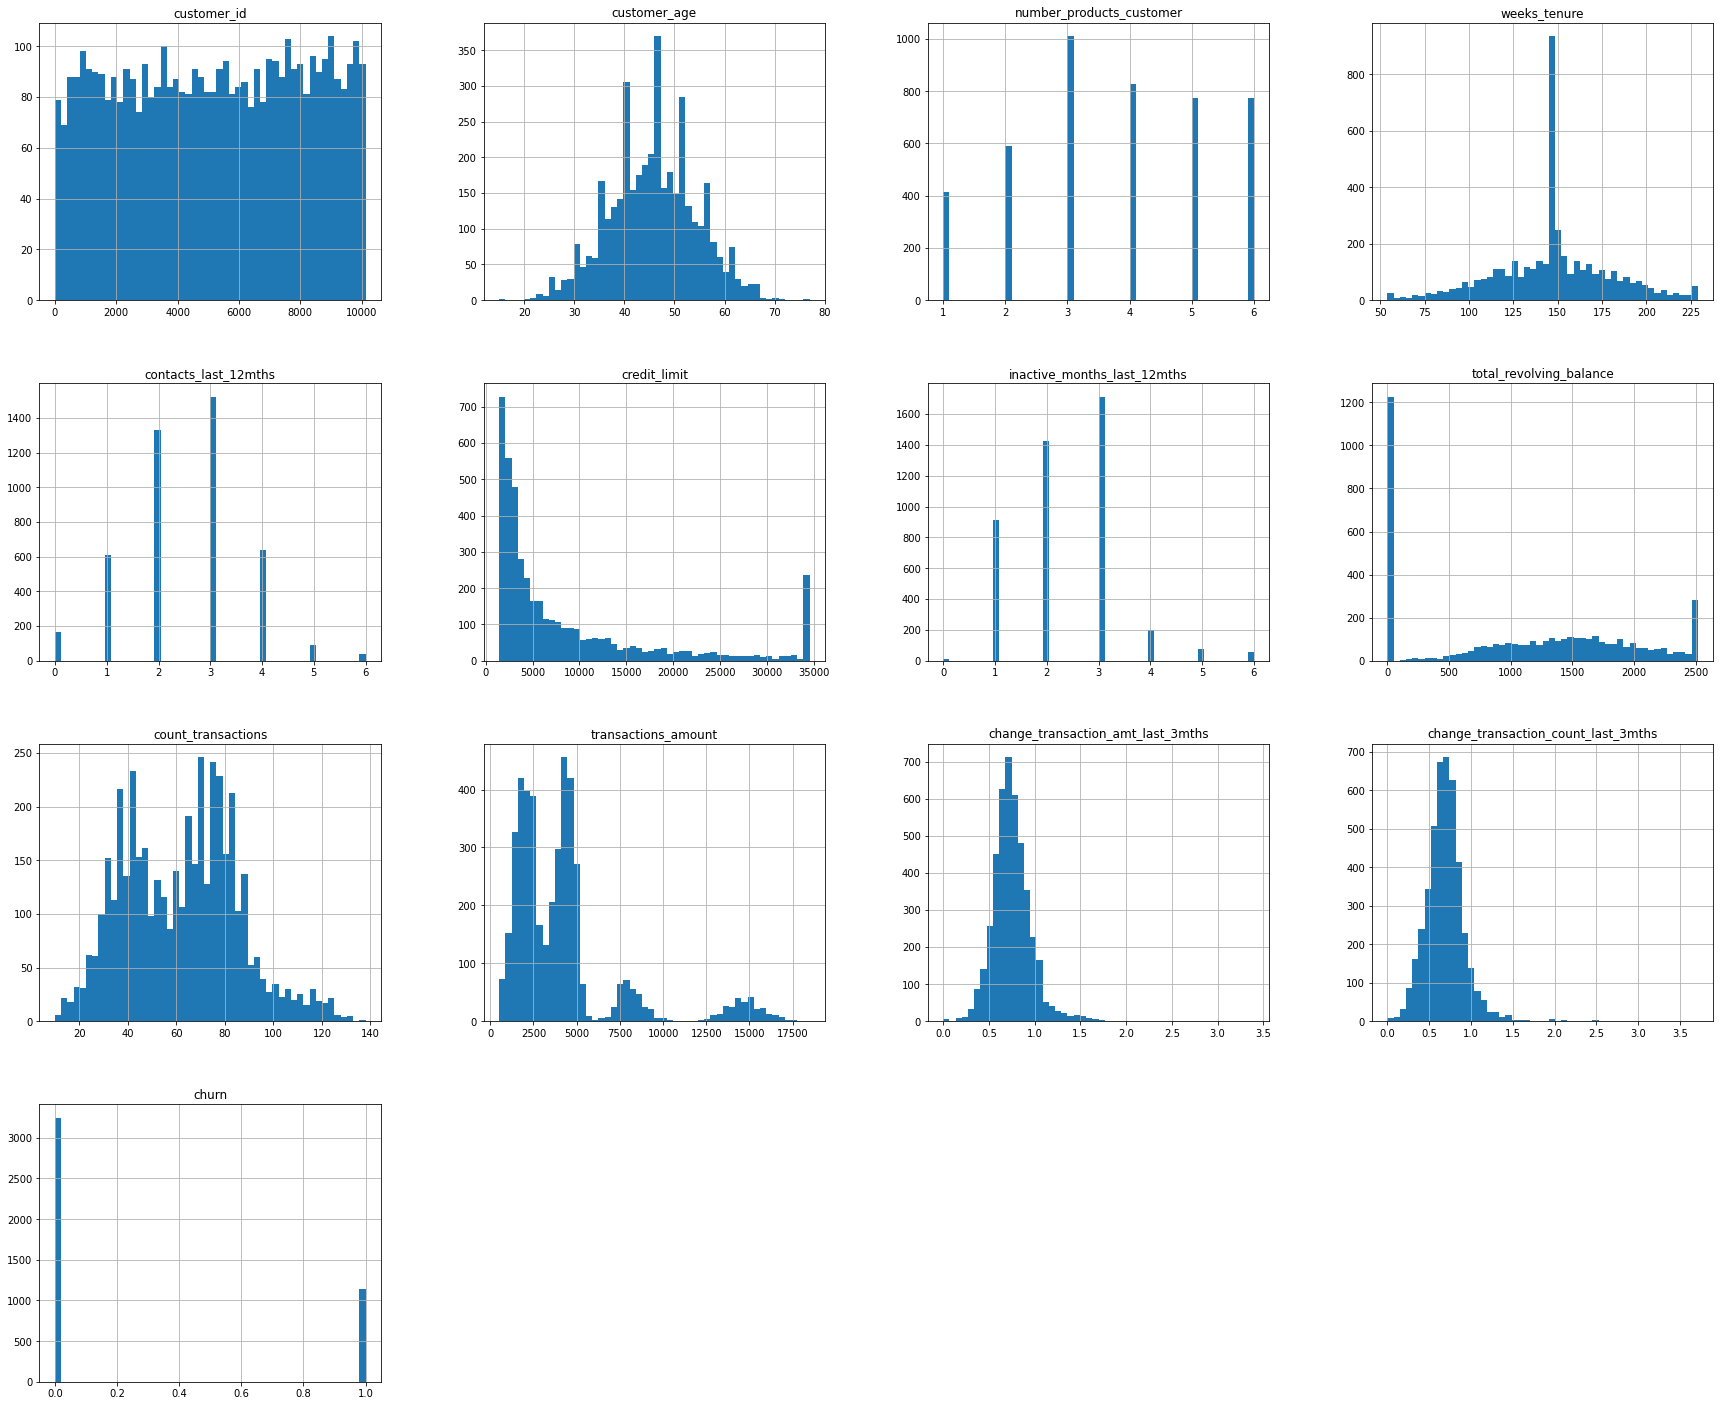

In [13]:
credit_num.hist(bins=50,figsize=(30,25))
plt.show()

# Preprocesamiento Datos

In [14]:
credit_target = credit_train.pop('churn')
credit_train.pop('customer_id')

0       4278
1       7300
2       6857
3       2508
4       7859
        ... 
4387    8590
4388    8131
4389    3445
4390    2832
4391     529
Name: customer_id, Length: 4392, dtype: int64

In [15]:
#credit_train.pop('customer_age')
#credit_train.pop('weeks_tenure')
credit_train.pop('credit_limit')

0       16541.0
1        1438.3
2        2293.0
3       17523.0
4        4391.0
         ...   
4387     3184.0
4388     5139.0
4389     2094.0
4390     5821.0
4391     5261.0
Name: credit_limit, Length: 4392, dtype: float64

In [16]:
credit_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4392 entries, 0 to 4391
Data columns (total 14 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   customer_age                         3963 non-null   float64
 1   education_level                      3735 non-null   object 
 2   marital_status                       4074 non-null   object 
 3   income_category                      3891 non-null   object 
 4   number_products_customer             4392 non-null   int64  
 5   weeks_tenure                         4392 non-null   int64  
 6   contacts_last_12mths                 4392 non-null   int64  
 7   card_class                           4392 non-null   object 
 8   inactive_months_last_12mths          4392 non-null   int64  
 9   total_revolving_balance              4392 non-null   int64  
 10  count_transactions                   4392 non-null   int64  
 11  transactions_amount           

## Datos Numéricos

In [17]:
attributes_num = [name for name in credit_train.columns if credit_train[name].dtype in ['int64', 'float64']]
credit_num = credit_train[attributes_num]

## Datos Categóricos 

In [18]:
attributes_cat = [name for name in credit_train.columns if credit_train[name].dtype == "object"]
credit_cat = credit_train[attributes_cat]

## Pipelines de transformacion 

In [19]:
num_pipeline = Pipeline([
    ('imputer_num',SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('imputer_cat',SimpleImputer(strategy='most_frequent')),
    ('one',OrdinalEncoder(handle_unknown='error')),
])

num_attribs = list(credit_num)
cat_attribs = list(credit_cat)

full_pipeline = ColumnTransformer([
    ('num',num_pipeline,num_attribs),
    ('cat',cat_pipeline,cat_attribs),
])

credit_prepared = full_pipeline.fit_transform(credit_train)

# Modelo

## RandomForest

In [20]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

In [21]:
X_train, X_val, y_train, y_val = train_test_split(credit_prepared,credit_target, test_size=0.1, random_state=35)

In [22]:
model =RandomForestClassifier()
model.fit(X_train,y_train)

RandomForestClassifier()

In [23]:
credit_pred = model.predict(X_val)
f1_score(y_val, credit_pred, average='binary')

0.8907563025210085

## Mejorar el modelo

In [24]:
from sklearn.metrics import f1_score, make_scorer

f1 = make_scorer(f1_score , average='binary')

param_grid = [
    #{'bootstrap': [False], 'n_estimators': [100,200,300],'min_samples_split':[4,8,12],'min_samples_leaf':[2,4,6,8]},
    {'n_estimators': [100,200,300],'max_depth': [5,10,15,20],'min_samples_split':[4,8,12],'min_samples_leaf':[2,4,6,8]},
]

forest_reg = RandomForestClassifier(class_weight={0:1,1:3},max_features= None)
#forest_reg = RandomForestClassifier(class_weight='balanced')

grid_search_forest = GridSearchCV(forest_reg,param_grid,cv=2,
                          scoring=f1,
                          return_train_score=True)

grid_search_forest.fit(credit_prepared, credit_target)

GridSearchCV(cv=2,
             estimator=RandomForestClassifier(class_weight={0: 1, 1: 3},
                                              max_features=None),
             param_grid=[{'max_depth': [5, 10, 15, 20],
                          'min_samples_leaf': [2, 4, 6, 8],
                          'min_samples_split': [4, 8, 12],
                          'n_estimators': [100, 200, 300]}],
             return_train_score=True,
             scoring=make_scorer(f1_score, average=binary))

In [25]:
grid_search_forest.best_params_

{'max_depth': 15,
 'min_samples_leaf': 2,
 'min_samples_split': 4,
 'n_estimators': 300}

In [26]:
cvres = grid_search_forest.cv_results_
for mean_score,params in zip(cvres['mean_test_score'], cvres['params']):
    print(mean_score, params)

0.8397489490169538 {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 100}
0.839917659770804 {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 200}
0.8432469173686521 {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 300}
0.8456548522889326 {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 100}
0.8395392516122253 {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 200}
0.8393479266325745 {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 300}
0.8403713814573268 {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 12, 'n_estimators': 100}
0.8392998323898675 {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 12, 'n_estimators': 200}
0.8390894571839816 {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 12, 'n_estimators': 300}
0.8390618530275845 {'max_depth': 5, 'min_samples_leaf': 4, 'mi